## Now for the fun part

We've gotten the hard part over with. TO THE CHARTS!

In [2]:
import pandas as pd
import altair as alt
from altair.expr import datum,if_

Let's check out some enrollment numbers first.

In [3]:
enrollment = pd.read_csv("data/vt_enrollment.csv")

enrollment_chg = pd.read_csv("data/vt_enrollment_change.csv")
tot_enrollment = pd.read_csv("data/vt_total_enrollment.csv")
tot_enrollment["year"] = pd.to_datetime(
    tot_enrollment["year"], format="%Y"
)

enrollment["year"] = pd.to_datetime(
    enrollment["year"], format="%Y"
)

# filter out schools that are now closed
enrollment_current = enrollment[enrollment["exists"] == True]

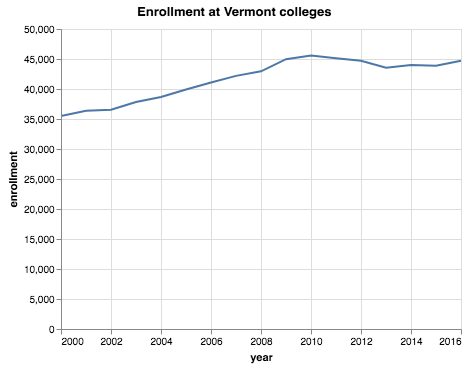

In [4]:
alt.Chart(tot_enrollment).mark_line().encode(
    x='year:T',
    y='enrollment:Q'
).properties(
    title="Enrollment at Vermont colleges"
)

Hmm. There's an upward trend there, at least until 2010. Let's see what that looks like if we break out all schools.

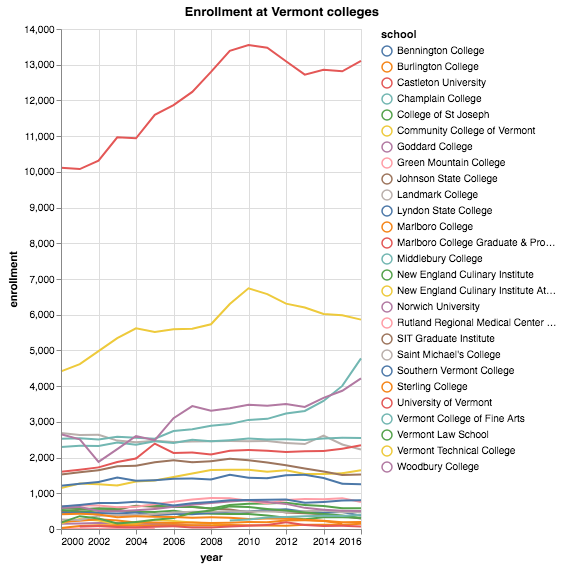

In [5]:
alt.Chart(enrollment).mark_line().encode(
    x='year:T',
    y='enrollment:Q',
    color="school"
).properties(
    width=300,
    height=500,
    title="Enrollment at Vermont colleges"
)

Well that's pretty crazy, but we can definitely see that UVM is having an impact on the total numbers for the state.

So let's make a bunch of tiny, adorable charts and see what each school looks like.

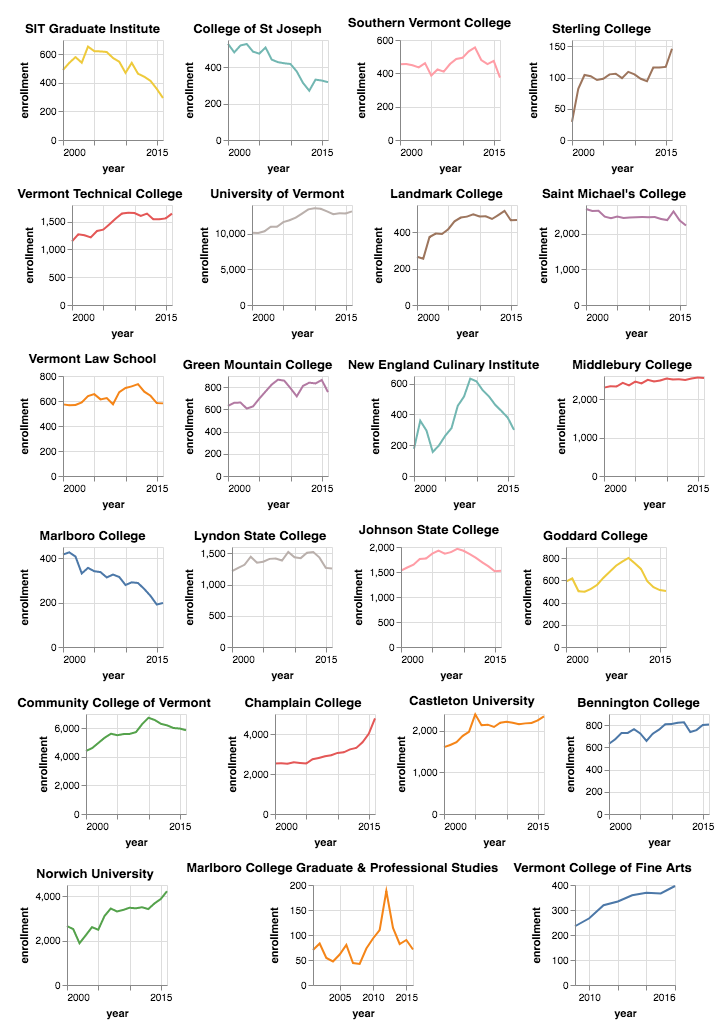

In [6]:
base=alt.Chart(enrollment_current).mark_line().encode(
    x='year:T',
    y='enrollment:Q',
    color=alt.Color('school:N', legend=None),
).properties(
    width=100,
    height=100,
)

subplts = []

for school in enrollment_current["school"].unique():
    subplts.append(base.transform_filter(datum.school==school).properties(
    title=school))
    
def facet_wrap(subplts, plots_per_row):
    rows = [subplts[i:i+plots_per_row] for i in range(0, len(subplts), plots_per_row)]
    compound_chart = alt.hconcat()
    for r in rows:
        rowplot = alt.vconcat() #start a new row
        for item in r:
            rowplot |= item #add suplot to current row as a new column
        compound_chart &= rowplot # add the entire row of plots as a new row
    return compound_chart


enroll_chart = facet_wrap(
    subplts, plots_per_row=4
)
enroll_chart

Let's see what school has the greatest 10-year decline in enrollment.

In [7]:
enrollment_chg.sort_values("change").head()

,UNITID,school,2007,2016,change
13,231068,SIT Graduate Institute,616.0,294.0,-0.522727
8,230940,Marlboro College,313.0,198.0,-0.367412
10,230977,New England Culinary Institute,456.0,300.0,-0.342105
14,231077,College of St Joseph,442.0,318.0,-0.280543
4,230889,Goddard College,678.0,505.0,-0.255162


How about increase?

In [8]:
enrollment_chg.sort_values("change", ascending=False).head()

,UNITID,school,2007,2016,change
2,230852,Champlain College,2796.0,4778.0,0.708870
21,440411,Marlboro College Graduate & Professional Studies,44.0,71.0,0.613636
16,231095,Sterling College,106.0,146.0,0.377358
11,230995,Norwich University,3442.0,4219.0,0.225741
0,230816,Bennington College,723.0,805.0,0.113416


*Note that while Marlboro's enrollment has declined, its graduate enrollment has risen; I confirmed with IPEDS that there's no double-counting here, so for our final analysis we combined the numbers to get the overall total enrollment at Marlboro College programs.*

*It's worth being on the lookout for instances like this, where an institution may be reporting numbers as a subsidiary of another institution, or may have changed the way they report numbers.*

Moving on, let's see what we can see on admissions. How about some more tiny, cute charts?

In [9]:
admissions = pd.read_csv("data/vt_admissions.csv")
admissions["year"] = pd.to_datetime(admissions["year"], format="%Y")

#filter closed schools
admissions = admissions[admissions["exists"] == True]

admissions.head()

,UNITID,school,applications,admissions,year,exists,admit_rate
2,231077,College of St Joseph,101.0,89.0,2007-01-01,True,0.881188
3,231086,Southern Vermont College,344.0,316.0,2007-01-01,True,0.918605
4,231095,Sterling College,97.0,74.0,2007-01-01,True,0.762887
5,231165,Vermont Technical College,862.0,486.0,2007-01-01,True,0.563805
6,231174,University of Vermont,18814.0,13079.0,2007-01-01,True,0.695174


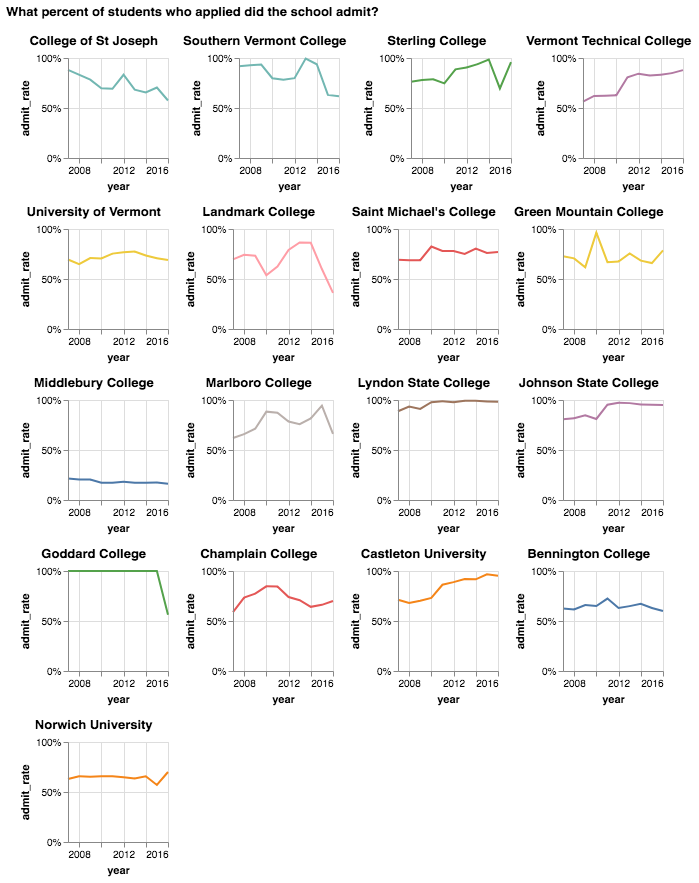

In [10]:
 base=alt.Chart(admissions).mark_line().encode(
    alt.X('year:T'),
    alt.Y('admit_rate:Q', 
          axis=alt.Axis(format="%"),
         scale={"domain":[0, 1]}),
    color=alt.Color('school:N', legend=None),
).properties(
    width=100,
    height=100,
)

subplts = []
for school in admissions["school"].unique():
    subplts.append(base.transform_filter(datum.school==school).properties(
    title=school))
    
def facet_wrap(subplts, plots_per_row):
    rows = [subplts[i:i+plots_per_row] for i in range(0, len(subplts), plots_per_row)]
    compound_chart = alt.hconcat()
    for r in rows:
        rowplot = alt.vconcat() #start a new row
        for item in r:
            rowplot |= item #add suplot to current row as a new column
        compound_chart &= rowplot # add the entire row of plots as a new row
    return compound_chart


admit_chart = facet_wrap(
    subplts, plots_per_row=4
).properties(title="What percent of students who applied did the school admit?")   
admit_chart 

Interesting. Now let's check out where undergraduate first-years were from in 2016.

In [11]:
vt_geo = pd.read_csv("data/vt_student_geo.csv")
vt_geo.head()

,UNITID,school,region,students,percent
0,230816,Bennington College,in-state,9.0,0.041284
1,230834,Castleton University,in-state,315.0,0.661765
2,230852,Champlain College,in-state,106.0,0.159879
3,230861,Community College of Vermont,in-state,522.0,0.932143
4,230889,Goddard College,in-state,1.0,0.111111


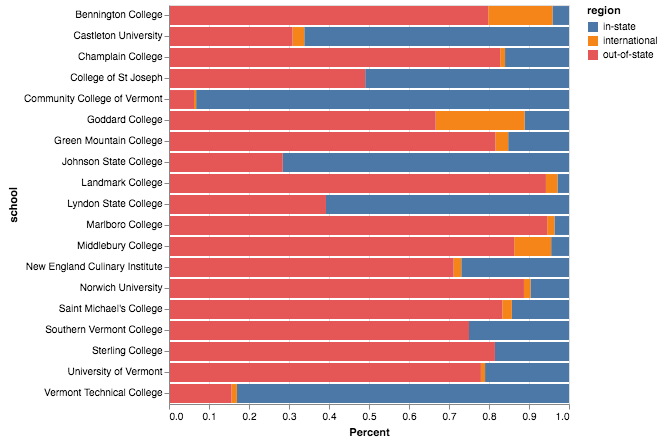

In [12]:
alt.Chart(vt_geo).mark_bar().encode(
    x=alt.X('sum(students)',
            axis=alt.Axis(title="Percent"),
           stack="normalize"),
    y="school:N",
    color="region:N",
    tooltip=["school","region","students"]
)

Meh, that doesn't look great. Let's do some funky things that will give us an order column, so we can tell Altair how to put everything in the right order.

In [13]:
vt_geo = vt_geo.sort_values([
    "region","percent"
]).reset_index(
    drop=True
)[["UNITID","school","region","students","percent"]].reset_index().rename(columns={"index":"sort"})

vt_geo.head()

,sort,UNITID,school,region,students,percent
0,0,247649,Landmark College,in-state,3.0,0.028846
1,1,230940,Marlboro College,in-state,2.0,0.036364
2,2,230816,Bennington College,in-state,9.0,0.041284
3,3,230959,Middlebury College,in-state,27.0,0.044554
4,4,230995,Norwich University,in-state,77.0,0.096370


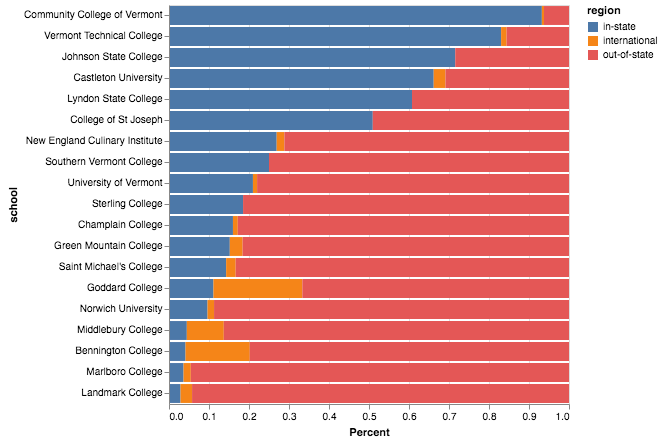

In [14]:
alt.Chart(vt_geo).mark_bar().encode(
    x=alt.X('sum(students)',
            axis=alt.Axis(title="Percent"),
           stack="normalize"),
    y=alt.Y("school:N",
           sort={
               "op": "distinct", 
               "field": "sort:Q",
               "order":"descending"
           }),
    color="region:N",
    order= alt.Order('region:N', sort='ascending'),
    tooltip=["school","region","students","percent"]
)

Much better!

Now let's check out some financial data. First up, tuition and fees.

In [15]:
finance = pd.read_csv("data/vt_finance.csv")
finance.head()

,UNITID,exists,expenses,revenues,school,tuition_fees,year
0,230825,False,3312041.0,3280605,Burlington College,2707575,2008
1,231068,True,110696345.0,100112579,SIT Graduate Institute,45703647,2008
2,231077,True,5217743.0,5059533,College of St Joseph,3574137,2008
3,231086,True,9233912.0,9075000,Southern Vermont College,5477954,2008
4,231095,True,4037075.0,3696866,Sterling College,1477151,2008


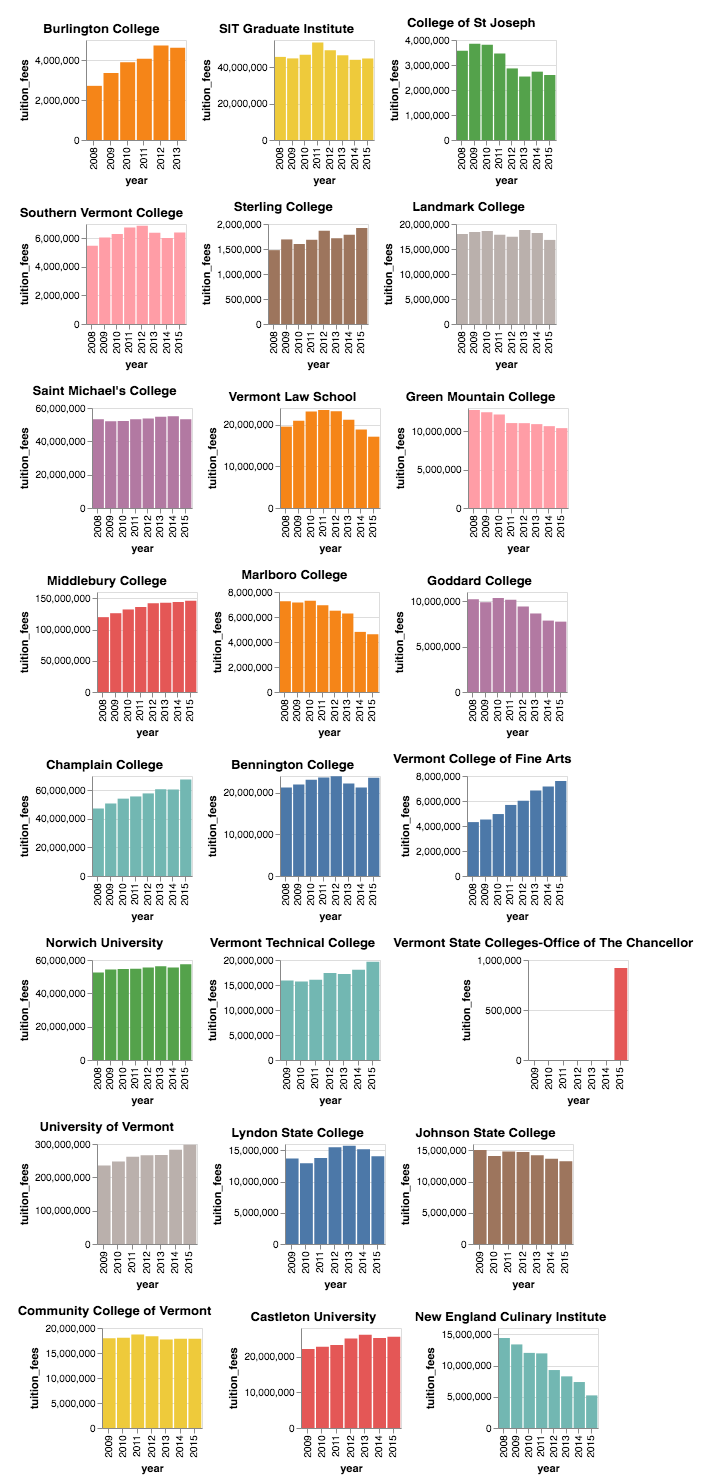

In [16]:
base=alt.Chart(finance).mark_bar().encode(
    x='year:O',
    y='tuition_fees:Q',
    color=alt.Color('school:N', legend=None),
).properties(
    width=100,
    height=100,
)

subplts = []
for school in finance["school"].unique():
    subplts.append(base.transform_filter(datum.school==school).properties(
            title=school))
    
def facet_wrap(subplts, plots_per_row):
    rows = [subplts[i:i+plots_per_row] for i in range(0, len(subplts), plots_per_row)]
    compound_chart = alt.hconcat()
    for r in rows:
        rowplot = alt.vconcat() #start a new row
        for item in r:
            rowplot |= item #add suplot to current row as a new column
        compound_chart &= rowplot # add the entire row of plots as a new row
    return compound_chart


expense_chart = facet_wrap(subplts, plots_per_row=3)  
expense_chart

If we wanted to drill down further, we might want to plot these numbers side by side with enrollment numbers to see how those compare.

Also, note that `Vermont State Colleges - Office of the Chancellor` chart. If we were going to use overall tuition numbers for any of the Vermont State Colleges, we'd definitely want to check in on why some tuition is getting put in that bucket, rather than assigned to a particular school.

For now, let's move on and look at expenses and revenues.

Note that the following is a hack-y workaround for an [Altair faceting issue](https://github.com/altair-viz/altair/issues/991) (faceting a chart that is, itself, faceted throws an error). It will take a while to load. Hopefully this will be fixed in an upcoming Altair release.

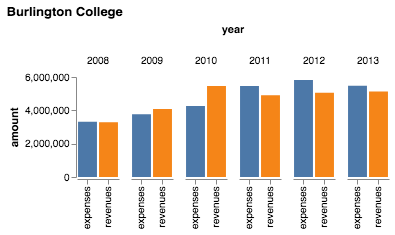

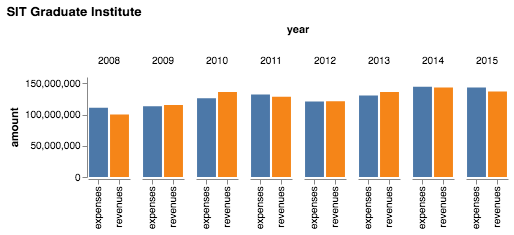

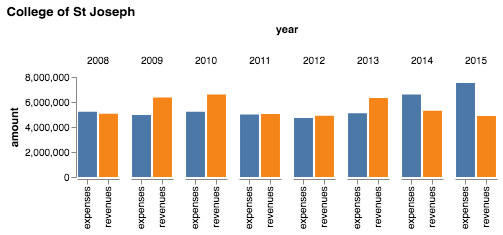

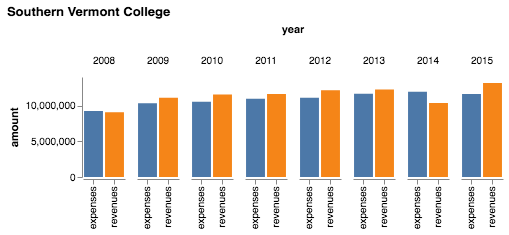

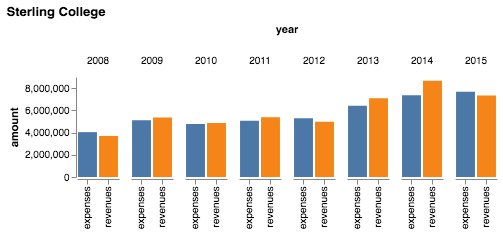

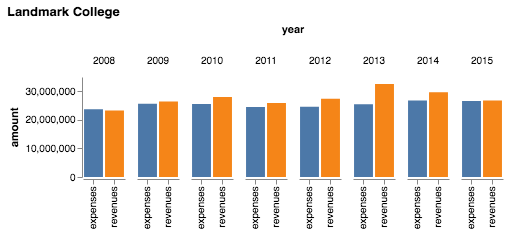

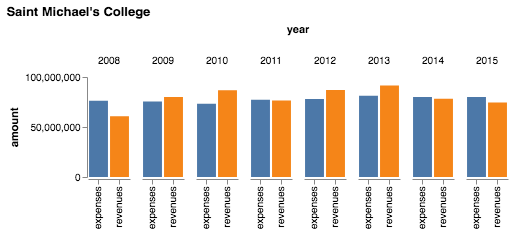

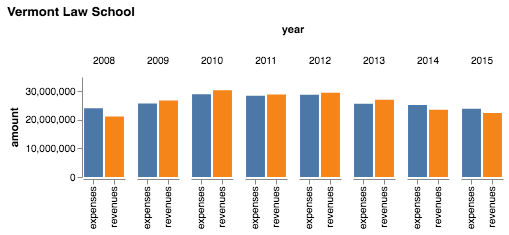

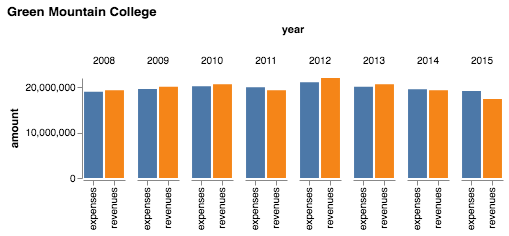

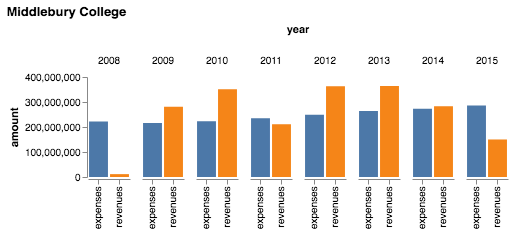

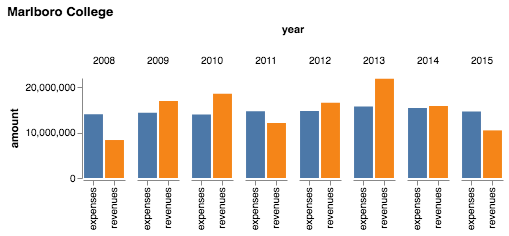

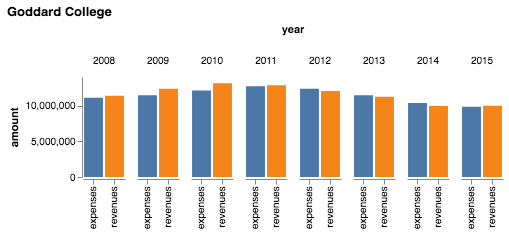

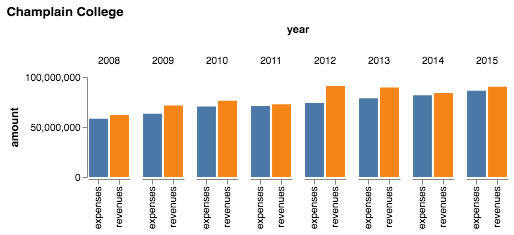

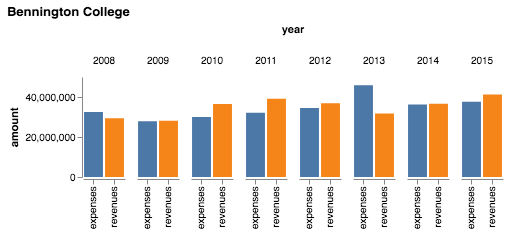

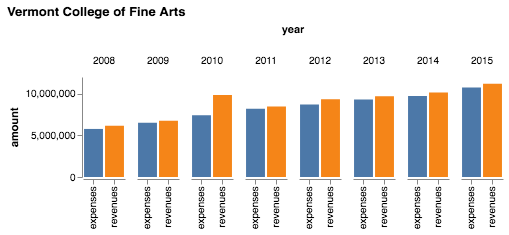

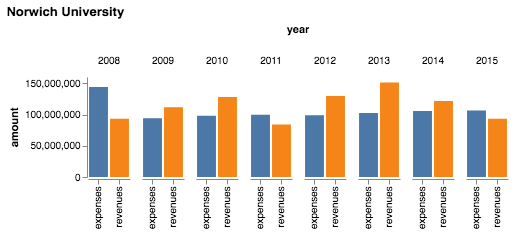

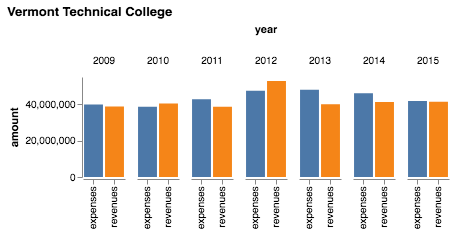

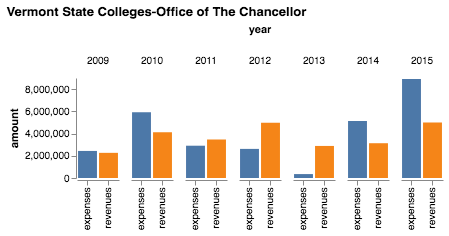

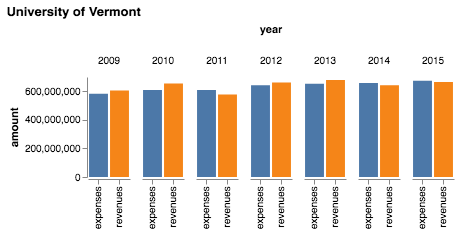

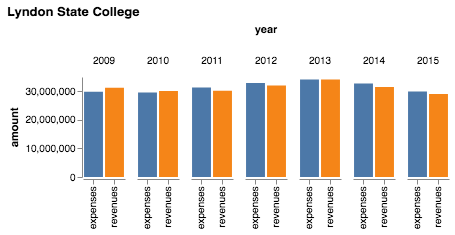

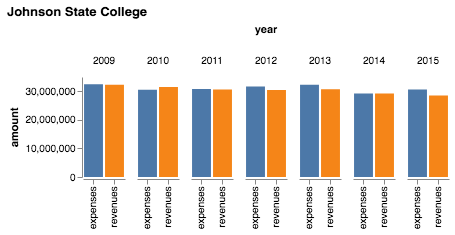

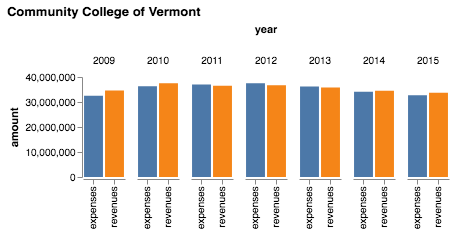

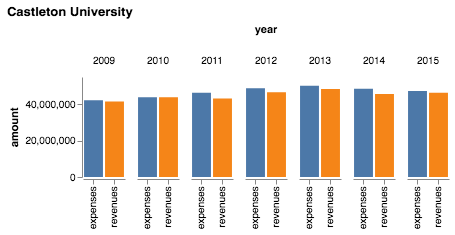

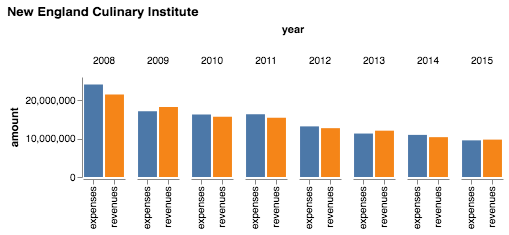

In [17]:
finance_melt = finance.melt(
                id_vars=["UNITID","school","year"], 
                value_vars=["expenses","revenues"],
                var_name="category"
            )

base = alt.Chart(finance_melt).mark_bar(stroke='transparent').encode(
    alt.X('category:N', axis=alt.Axis(title='')),
#     x="year:O",
    alt.Y('sum(value):Q', axis=alt.Axis(title='amount', grid=False)),
#     y='sum(value):Q',
    color=alt.Color("category:N",legend=None),
    column="year:O"
).configure_view(
    stroke='transparent'
)

subplts = []
for school in finance_melt["school"].unique():
    subplts.append(base.transform_filter(datum.school==school).properties(
            title=school, height=100))

for plot in subplts:
    display(plot)

And that's the quick version of this data exploration. Next steps: check numbers, double-check variable usage, figure out which graphics tell the story best, etc.

[Check out the story that came out of this exploratory analysis](https://www.sevendaysvt.com/vermont/survival-of-the-smartest-vermonts-colleges-must-adapt-as-pool-of-potential-students-declines/Content?oid=19763327), and explore some of these numbers in the interactive graphic at the bottom.